## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [23]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv(r'../ch03_Assignment/AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [24]:
df['logprice'] = np.log1p(df['price'])

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(df_train.shape, df_val.shape, df_test.shape)

(29337, 11) (9779, 11) (9779, 11)


In [27]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [28]:
y_train = (df_train.logprice).astype('int').values
y_val = (df_val.logprice).astype('int').values
y_test = (df_test.logprice).astype('int').values

In [29]:
del df_train['price']
del df_val['price']
del df_test['price']

del df_train['logprice']
del df_val['logprice']
del df_test['logprice']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [30]:
from sklearn.feature_extraction import DictVectorizer

In [31]:
train_dict = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

In [32]:
val_dict = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_val = dv.fit_transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [39]:
from sklearn.tree import DecisionTreeRegressor, export_text

In [40]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [43]:
from sklearn.metrics import roc_auc_score

y_pred = dt.predict(X_val)

In [45]:
def RMSE(y_pred, y):
    E = y - y_pred
    SE = E ** 2
    MSE = SE.mean()
    
    return np.sqrt(MSE)

In [47]:
RMSE(y_pred, y_val)

0.6298287647267291

In [48]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [3.81]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [4.66]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [56]:
from sklearn.ensemble import RandomForestRegressor

In [57]:
rf = RandomForestRegressor(n_estimators=10,
                           random_state=1, 
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [60]:
y_pred = rf.predict(X_val)

RMSE(y_pred, y_val)

0.5621877506494283

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [64]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = RMSE(y_pred, y_val)
    
    scores.append((n, rmse))

In [65]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

In [68]:
df_scores[df_scores['rmse'] == max(df_scores['rmse'])]['n_estimators']

0    10
Name: n_estimators, dtype: int64

In [69]:
df_scores

,n_estimators,rmse
0,10,0.562188
1,20,0.548675
2,30,0.545106
3,40,0.542945
4,50,0.541621
5,60,0.540695
6,70,0.540693
7,80,0.539968
8,90,0.539581
9,100,0.539191


After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [70]:
scores = []
for max_depth in [10, 15, 20, 25]:
    rf = RandomForestRegressor(max_depth=max_depth, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = RMSE(y_pred, y_val)
    
    scores.append((max_depth, rmse))

In [71]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'rmse'])
df_scores[df_scores['rmse'] == max(df_scores['rmse'])]['max_depth']

3    25
Name: max_depth, dtype: int64

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [73]:
rf = RandomForestRegressor(n_estimators=10,
                            max_depth=20,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [79]:
len(rf.feature_importances_)

15

In [92]:
feature_imp = zip(dv.feature_names_, rf.feature_importances_)
for feature, imp in feature_imp:
    print(feature, imp)

availability_365 0.08268491559352083
calculated_host_listings_count 0.03163012351077089
latitude 0.16407485107426453
longitude 0.17305058795970915
minimum_nights 0.058366351260806984
neighbourhood_group=Bronx 0.000365312211331072
neighbourhood_group=Brooklyn 0.0010073887350848826
neighbourhood_group=Manhattan 0.028776259457364447
neighbourhood_group=Queens 0.001693355475457051
neighbourhood_group=Staten Island 0.00011871416726760457
number_of_reviews 0.051178604933978224
reviews_per_month 0.06666269060577394
room_type=Entire home/apt 0.3319792574486188
room_type=Private room 0.00447487110288585
room_type=Shared room 0.003936716463165996


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [93]:
import xgboost as xgb

In [94]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [95]:
%%capture output
watchList = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
}

model = xgb.train(xgb_params,
                  dtrain,
                  evals=watchList,
                  verbose_eval=1,
                  num_boost_round=100)

In [96]:
s = output.stdout
print(s)

[0]	train-rmse:2.71353	val-rmse:2.71043
[1]	train-rmse:1.94121	val-rmse:1.93845
[2]	train-rmse:1.41468	val-rmse:1.41331
[3]	train-rmse:1.06325	val-rmse:1.06419
[4]	train-rmse:0.83721	val-rmse:0.84062
[5]	train-rmse:0.69843	val-rmse:0.70414
[6]	train-rmse:0.61746	val-rmse:0.62587
[7]	train-rmse:0.57208	val-rmse:0.58275
[8]	train-rmse:0.54725	val-rmse:0.55942
[9]	train-rmse:0.53363	val-rmse:0.54755
[10]	train-rmse:0.52558	val-rmse:0.54108
[11]	train-rmse:0.52075	val-rmse:0.53698
[12]	train-rmse:0.51762	val-rmse:0.53507
[13]	train-rmse:0.51568	val-rmse:0.53445
[14]	train-rmse:0.51340	val-rmse:0.53362
[15]	train-rmse:0.51132	val-rmse:0.53317
[16]	train-rmse:0.50974	val-rmse:0.53299
[17]	train-rmse:0.50872	val-rmse:0.53274
[18]	train-rmse:0.50758	val-rmse:0.53239
[19]	train-rmse:0.50653	val-rmse:0.53246
[20]	train-rmse:0.50457	val-rmse:0.53166
[21]	train-rmse:0.50440	val-rmse:0.53187
[22]	train-rmse:0.50333	val-rmse:0.53207
[23]	train-rmse:0.50300	val-rmse:0.53200
[24]	train-rmse:0.50148	va

In [97]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [98]:
df_score = parse_xgb_output(output)

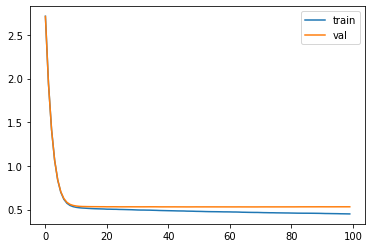

In [99]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

Now change `eta` first to `0.1` and then to `0.01`

In [101]:
scores = {}

In [105]:
%%capture output
watchList = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
}

model = xgb.train(xgb_params,
                  dtrain,
                  evals=watchList,
                  verbose_eval=1,
                  num_boost_round=200)

In [106]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [107]:
scores.keys()

dict_keys(['eta=0.1', 'eta=0.01'])

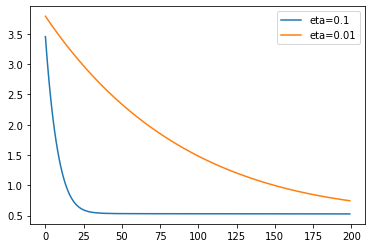

In [108]:
etas = ['eta=0.1', 'eta=0.01']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

